# Credit Card Fraud Detection


## Importing Libraries

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics #metrics librry

import missingno as msno
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import IPython
import plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from pylab import rcParams

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Other Libraries
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit as sss
import time
import matplotlib.patches as mpatches
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


rcParams['figure.figsize'] = 16, 8

##Loading the dataset from Kaggle

In [204]:
pip install kaggle

In [206]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"rishabkamshetty","key":"5526af95c0fad3b57a098dc0487148e8"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [210]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [212]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [213]:
!unzip /content/{/content}/datasets/mlg-ulb/creditcardfraud/creditcardfraud.zip

Archive:  /content/{/content}/datasets/mlg-ulb/creditcardfraud/creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Import dataset to Dataframe

In the following cells, we will import our dataset from a .csv file as a Pandas DataFrame.  Furthermore, we will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset.  For this purpose, we will use Pandas' built-in describe feature, as well as parameter histograms and a correlation matrix. 

In [0]:
df = pd.read_csv('creditcard.csv')

In [215]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [216]:
print(df.shape)
print(df.describe())
# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(284807, 31)
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


##Data Exploration

Is there any missing values

In [217]:
df.isna().values.any()

False

No missing values

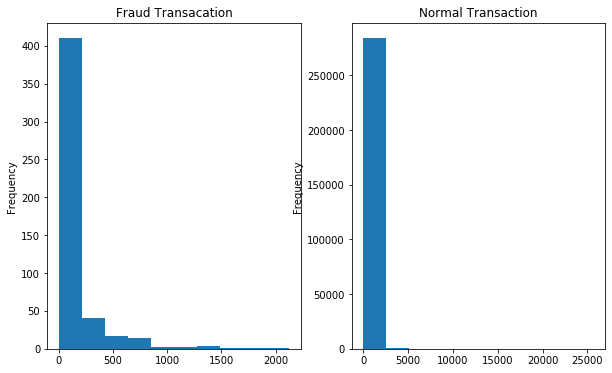

In [218]:
Fraud_transacation = df[df["Class"]==1]
Normal_transacation= df[df["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
Fraud_transacation.Amount.plot.hist(title="Fraud Transacation")
plt.subplot(122)
Normal_transacation.Amount.plot.hist(title="Normal Transaction")

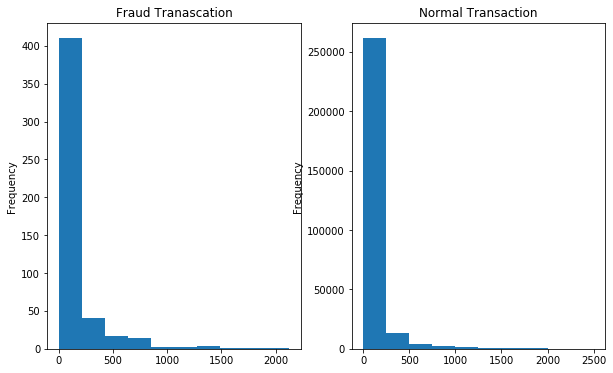

In [219]:
# the distribution for Normal transction is not clear and it seams that all transaction are less than 2.5 K
# So plot graph for same 
Fraud_transacation = df[df["Class"]==1]
Normal_transacation= df[df["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
Fraud_transacation[Fraud_transacation["Amount"]<= 2500].Amount.plot.hist(title="Fraud Tranascation")
plt.subplot(122)
Normal_transacation[Normal_transacation["Amount"]<=2500].Amount.plot.hist(title="Normal Transaction")

In [220]:
# Our data set is heavily imbalanced
print('Valid Transaction vs Fraud ')
print(round(df['Class'].value_counts()[0]/len(df) * 100,2),':', round(df['Class'].value_counts()[1]/len(df) * 100,2))

Valid Transaction vs Fraud 
99.83 : 0.17


0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Frequency')

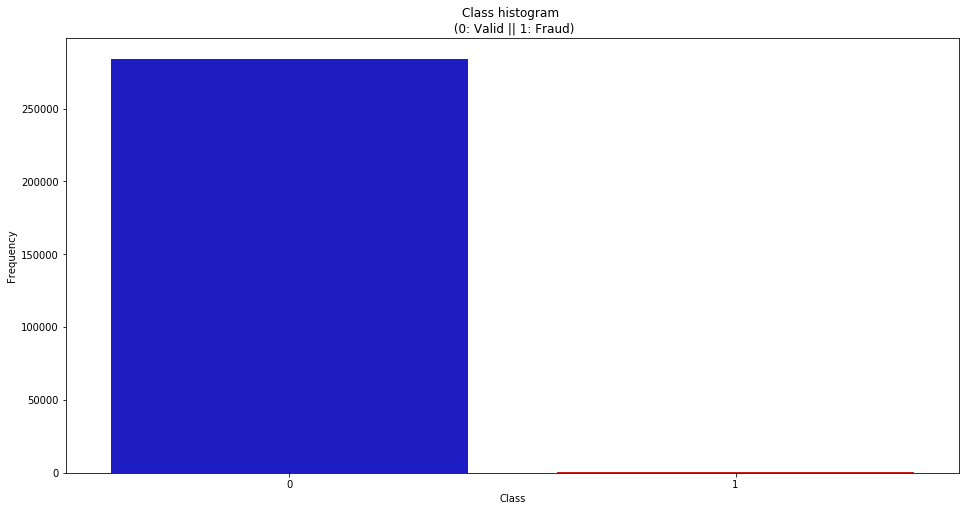

In [221]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
print(count_classes)
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=16)
plt.title("Class histogram \n (0: Valid || 1: Fraud)")
plt.xlabel("Class")
plt.ylabel("Frequency")

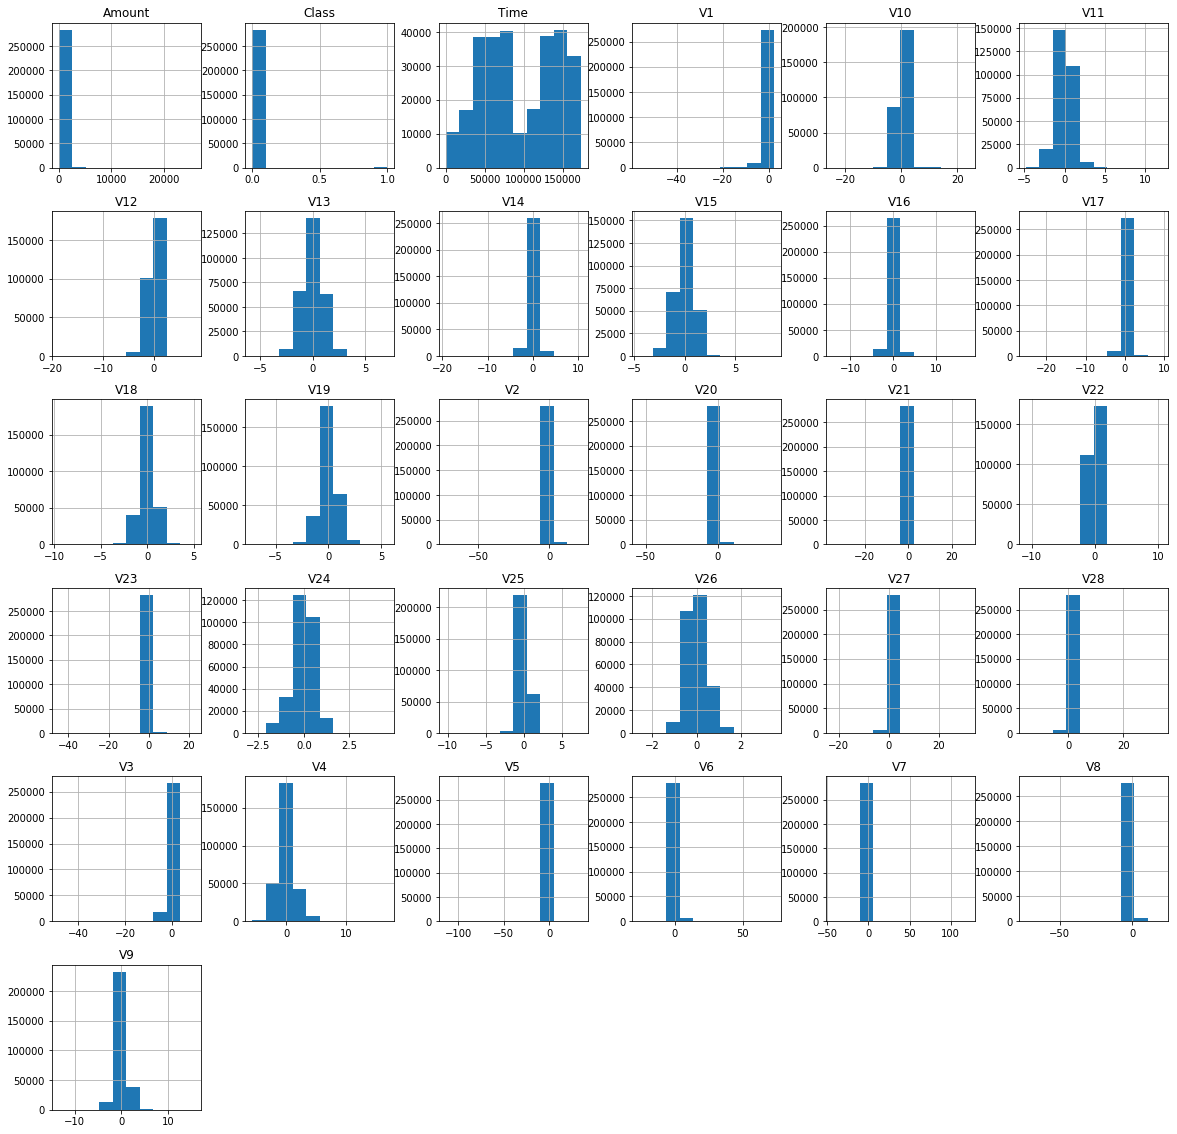

In [222]:
# Plot histograms of each parameter 
df.hist(figsize = (20, 20))
plt.show()

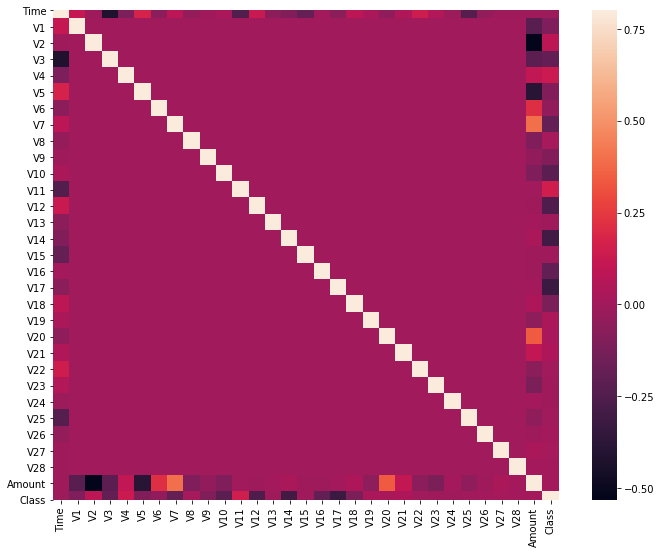

In [223]:
# Correlation matrix
corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [0]:
df_ann=df.copy()

#Supervised Models

##Supervised Model with oversampling Minority Classes(SMOTE)

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [0]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score

In [0]:
X = df.drop(["Class"], axis=1).values #Setting the X to do the split
y = df["Class"].values # transforming the values in array

In [141]:
# the function that we will use to better evaluate the model
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.20)

classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), \
                                   classifier(random_state=42))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


####Evaluating the model SMOTE + Random Forest

In [142]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)

Confusion Matrix: 
[[56853     9]
 [   19    81]]

SMOTE Pipeline Score 0.9995084442259752

SMOTE + RandomForest classification
accuracy: 0.9995084442259752
precision: 0.9
recall: 0.81
f2: 0.826530612244898


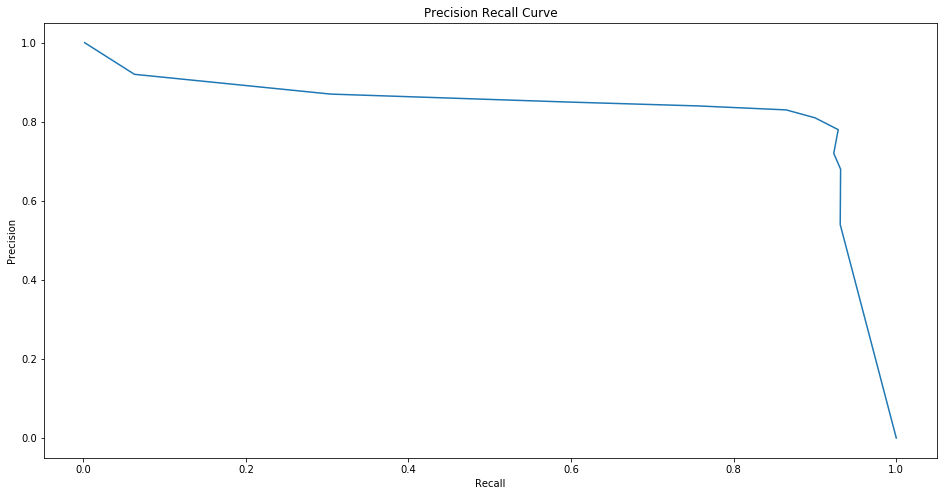

In [143]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

####Modelling Random Forest with Hyper Parameters

In [0]:
#params of the model
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[3,5,10],
              "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )

In [147]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy', max_depth=2,
                                              max_features=3,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=1,
                                              oob_score=False, random_state=3,
                                              verbose=1, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [

In [148]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7732867446650217
{'max_depth': 5, 'max_features': 7, 'n_estimators': 3}


In [149]:
# Running the fit
rf = RandomForestClassifier(max_depth=5, max_features = 7, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
# Printing the Training Score
print("Training score data: ")
print(rf.score(X_train, y_train))

Training score data: 
0.9995040488051088


In [151]:
#Testing the model 
#Predicting by X_test
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print_results("RF classification", y_test, y_pred)

[[56856     6]
 [   26    74]]
RF classification
accuracy: 0.9994382219725431
precision: 0.925
recall: 0.74
f2: 0.7708333333333333


####Result Summary on SMOTE


We got the best score when we use the SMOTE (OverSampling) + RandomForest, that performed a f2 score of **0.82653~**

This is a considerably difference by the second best model that is **0.77083~** that uses just RandomForests with some Hyper Parameters.

##Supervised Model with Sub-Sample(1:1 Ratio between classes)

###Split data

In [0]:
# We randomly select 492 genuine transactions
genuines_sub = Normal_transacation.sample(492, random_state=seed)

# dataset_sub is the dataset composed of 492 frauds and of 492 genuine transactions
dataset_sub = Fraud_transacation.append(genuines_sub, ignore_index=True)

# We drop the 'Time' column
dataset_sub = dataset_sub.drop('Time',axis=1)

print('This sub dataset contains ',dataset_sub.shape[0],'rows')
print('This sub dataset contains ',dataset_sub.shape[1],'columns')

This sub dataset contains  984 rows
This sub dataset contains  30 columns


In [0]:
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score

scoring = 'average_precision'

In [0]:
from sklearn.model_selection import train_test_split

# Predictors
X = dataset_sub.drop('Class',axis=1)

# Response
y = dataset_sub.Class

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = seed)

# Proportion of fraud in train set and test set
print('Proportion of fraud in train:',y_train[y_train == True].shape[0]/X_train.shape[0])
print('Proportion of fraud in test:',y_test[y_test == True].shape[0]/X_test.shape[0])

Proportion of fraud in train: 0.5108005082592122
Proportion of fraud in test: 0.45685279187817257


Set metrics

In [0]:
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score

scoring = 'average_precision'

Spot Check Algorithms
First, the following classifier would be tested:
*   Logistic Regression
*   Linear Discriminant Analysis
*   Support Vector Machine


Then the following Ensemble methods would be tested:
*   Random Forest
*   Stochastic Gradient Boosting
*   XGBoost





In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
import xgboost


models = []
models.append(('LR',LogisticRegression(random_state=seed)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('SVM',SVC(random_state=seed,gamma='scale')))

ensembles = []
ensembles.append(('RF', RandomForestClassifier(random_state=seed,n_estimators=100)))
ensembles.append(('GBM', GradientBoostingClassifier(random_state=seed)))
ensembles.append(('XGB', XGBClassifier(random_state=seed)))


 Train and Test Sets

First, we evaluate the performance of our classifier with a direct train-test stragtegy.

In [0]:
# Models evaluation function
def get_score_models(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    # All our models implement the 'decision_function' method
    # It is not the case of all our ensembles
    y_score = model.decision_function(X_test)
    
    compare(y_test,y_pred,y_score)
    
# Ensembles evaluation function
def get_score_ensembles(ensemble,X_train,X_test,y_train,y_test):
    ensemble.fit(X_train,y_train)
    y_pred = ensemble.predict(X_test)
    
    # All our ensembles implement the 'predict_proba' method
    # It is not the case of all our models
    y_score = ensemble.predict_proba(X_test)[:,1]
    
    compare(y_test,y_pred,y_score)

# Print metrics and graph function
def compare(y_test,y_pred,y_score):
    print('Confusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    
    print('Recall:',recall_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('Area under the curve:',average_precision_score(y_test,y_score))
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.step(recall, precision, alpha=0.4, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    plt.show()

---------- LR ----------
Confusion matrix:
[[102   5]
 [  7  83]]
Recall: 0.9222222222222223
Precision: 0.9431818181818182
Area under the curve: 0.9671510692760011


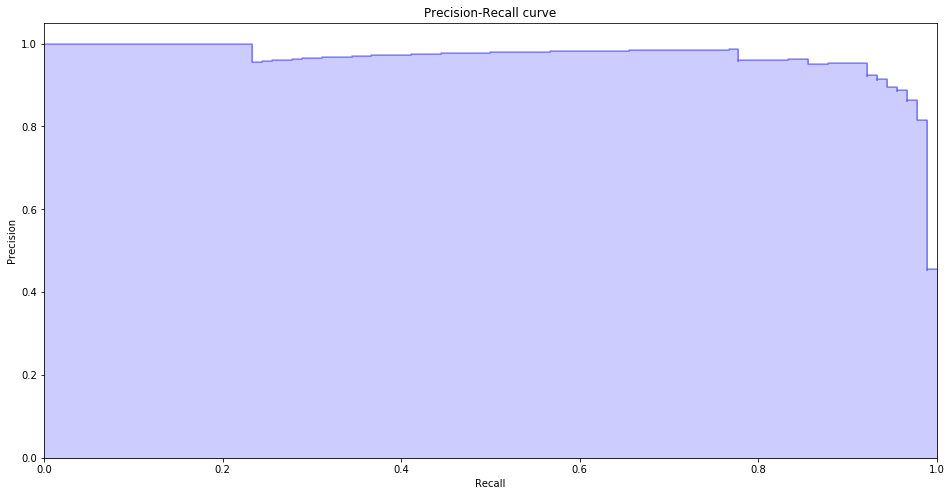

---------- LDA ----------
Confusion matrix:
[[103   4]
 [ 13  77]]
Recall: 0.8555555555555555
Precision: 0.9506172839506173
Area under the curve: 0.9259319943143265


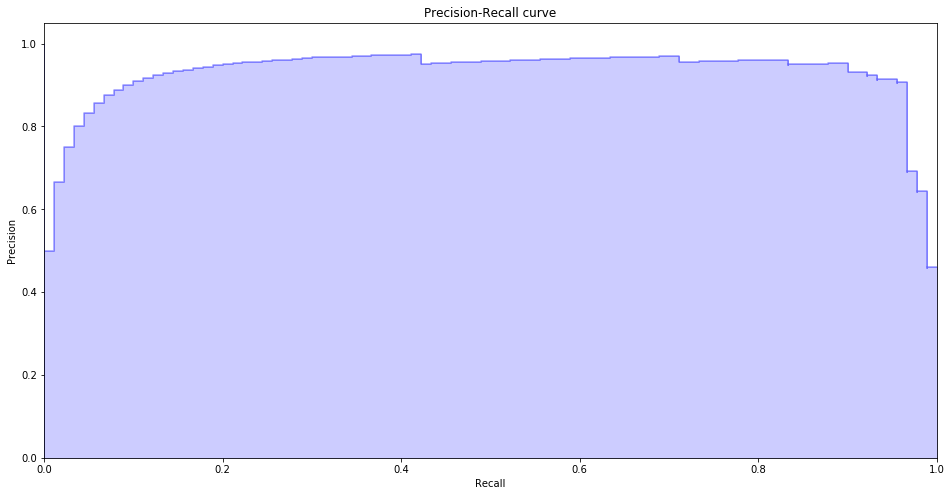

---------- SVM ----------
Confusion matrix:
[[101   6]
 [ 25  65]]
Recall: 0.7222222222222222
Precision: 0.9154929577464789
Area under the curve: 0.9435906459966247


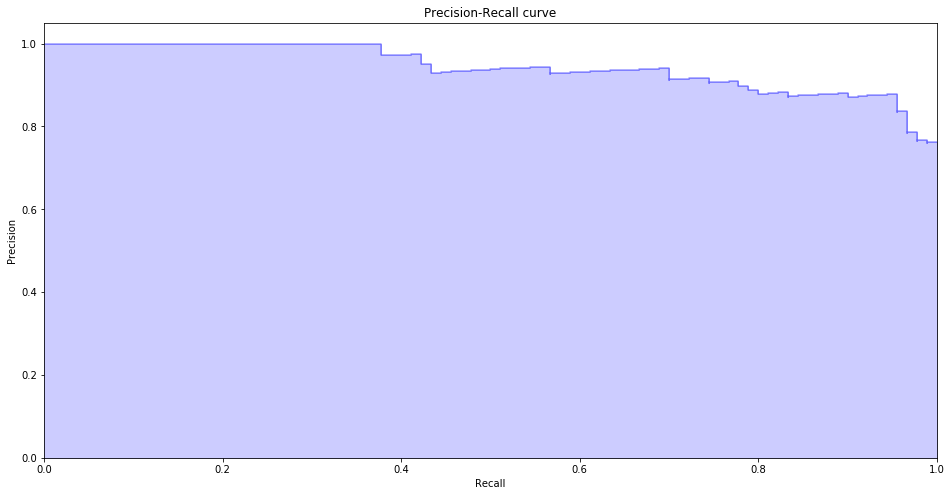

In [0]:
# Evaluation of each model
for name,model in models:
    print('----------',name,'----------')
    get_score_models(model,X_train,X_test,y_train,y_test)

---------- RF ----------
Confusion matrix:
[[102   5]
 [  8  82]]
Recall: 0.9111111111111111
Precision: 0.9425287356321839
Area under the curve: 0.984161871314936


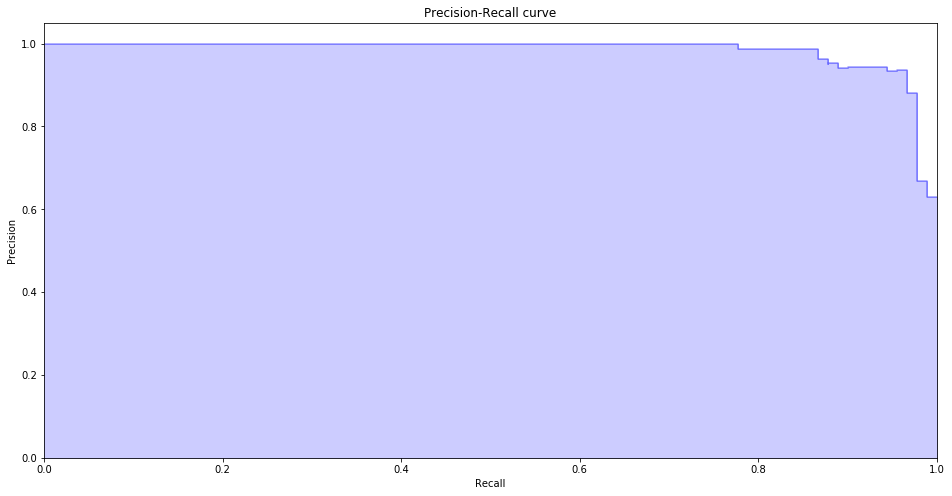

---------- GBM ----------
Confusion matrix:
[[103   4]
 [  7  83]]
Recall: 0.9222222222222223
Precision: 0.9540229885057471
Area under the curve: 0.9449186668704573


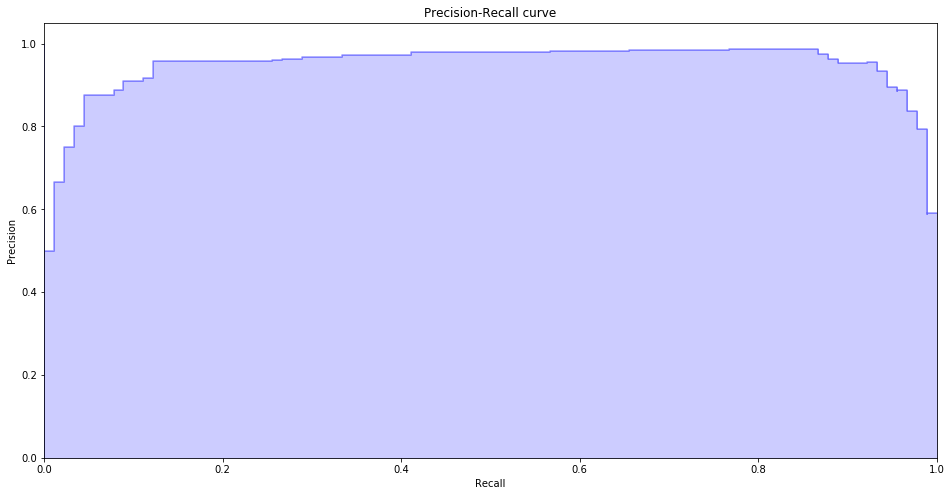

---------- XGB ----------
Confusion matrix:
[[102   5]
 [  5  85]]
Recall: 0.9444444444444444
Precision: 0.9444444444444444
Area under the curve: 0.9841756307441143


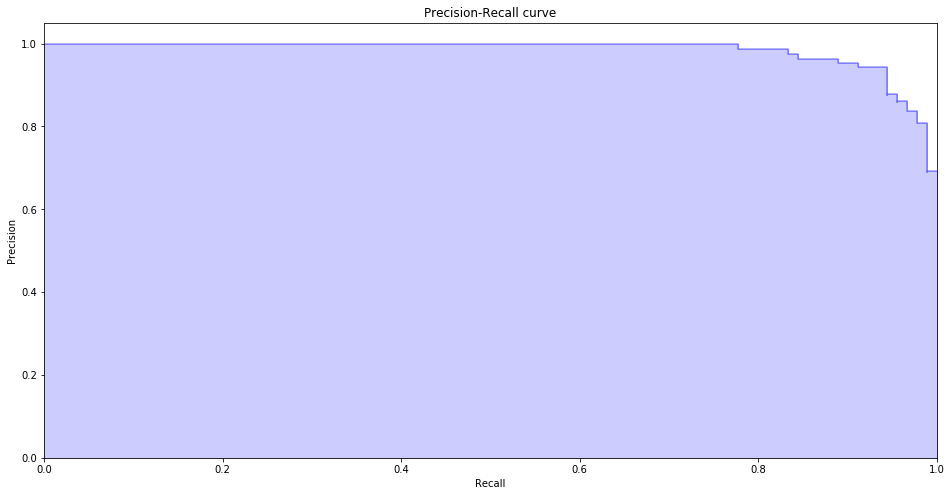

In [0]:
# Evaluation of each ensemble method
for name,ensemble in ensembles:
    print('----------',name,'----------')
    get_score_ensembles(ensemble,X_train,X_test,y_train,y_test)

**Train-Test Split conclusion**

Classifiers results:

Model	Recall(in %)	AUPRC(in %)	Precision(in %)

LR    	92.2	96.7	94.3

LDA	    85.6	92.6	95.1

SVM	   97.8	94.7	84.6

RF	94.4	98.4	95.5

GBM	92.2	94.5	95.4

XGB	94.4	98.4	94.4



*   Focused on Recall, the SVM classifier get the best score (on this particular Train-Test split). But in the same time, the SVM classifier has one of the poorest precision rate.


*  Regarding the Area under the Precision-Recall curve, Random Forest and XGBoost get the best score.












**K-Fold cross validation**




> 
Now, we evaluate the performance of our classifiers with a 10-Fold cross validation.




In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 10
kfold = KFold(n_splits=num_folds,random_state=seed)

names = []
results_recall = []
results_aupcr = []
models_score = {}
ensembles_score = {}

# Function cross validating and printing Recall and AUPRC results
def cross_validation(name,classifier,classifiers_score,results_recall,results_aupcr):
    cv_results_recall = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')
    cv_results_auprc = cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)

    models_score[name] = [cv_results_recall.mean()]
    models_score[name].append(cv_results_recall.std())
    models_score[name].append(cv_results_auprc.mean())
    models_score[name].append(cv_results_auprc.std())
    
    results_recall.append(cv_results_recall)
    results_aupcr.append(cv_results_auprc)
    names.append(name)

    print('----------',name,'----------')
    print('Recall:',models_score[name][0],'(',models_score[name][1],')')
    print('AUPRC:',models_score[name][2],'(',models_score[name][3],')\n')


In [0]:
# 10-Fold cross validation on our models
for name,model in models:
    cross_validation(name,model,models_score,results_recall,results_aupcr)

---------- LR ----------
Recall: 0.9132052706825204 ( 0.05739953397995212 )
AUPRC: 0.9832935383959646 ( 0.011372124102402096 )

---------- LDA ----------
Recall: 0.8533617365518277 ( 0.051487574015210515 )
AUPRC: 0.9732472764360562 ( 0.017218352439047024 )

---------- SVM ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )



In [0]:
# 10-Fold cross validation on ensembles
for name,ensemble in ensembles:
    cross_validation(name,ensemble,ensembles_score,results_recall,results_aupcr)

---------- RF ----------
Recall: 0.9112821937594434 ( 0.05950394047368563 )
AUPRC: 0.9869722414455142 ( 0.009265413503033379 )

---------- GBM ----------
Recall: 0.9112821937594434 ( 0.05950394047368563 )
AUPRC: 0.9869722414455142 ( 0.009265413503033379 )

---------- XGB ----------
Recall: 0.9112821937594434 ( 0.05950394047368563 )
AUPRC: 0.9869722414455142 ( 0.009265413503033379 )



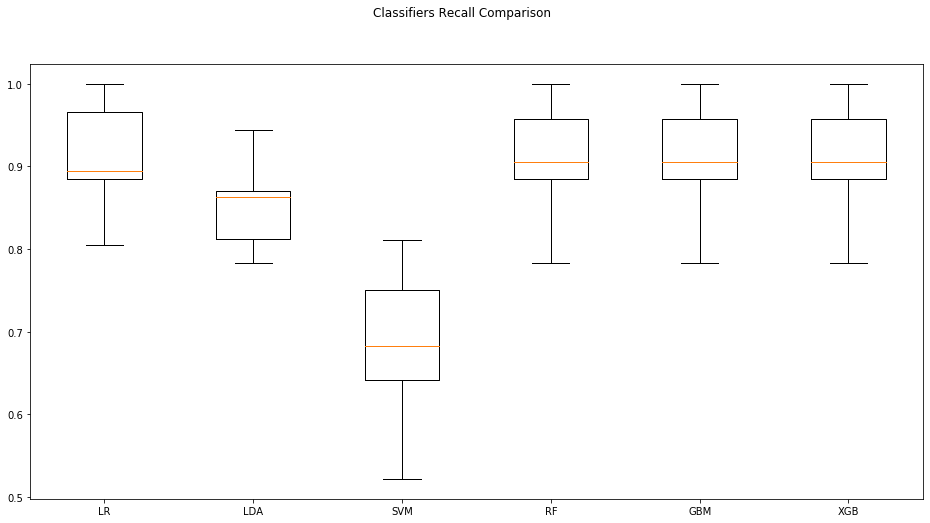

In [0]:
# Compare Classifiers regarding Recall
fig = plt.figure()
fig.suptitle('Classifiers Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_recall)
ax.set_xticklabels(names)
plt.show()

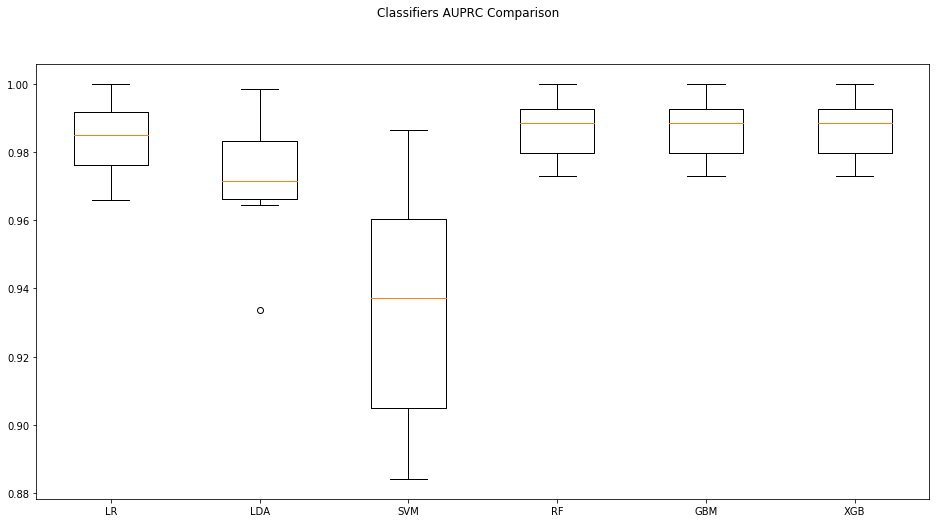

In [0]:
# Compare Classifiers regarding the Precision
fig = plt.figure()
fig.suptitle('Classifiers AUPRC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_aupcr)
ax.set_xticklabels(names)
plt.show()

**10-Fold cross validation conclusion**


> Classifiers results:

Model  Mean Recall(in %)  Std Recall(in %)   Mean AUPCR(in %)  Std AUPCR(in %)

LR 91.3  5.74   98.3  1.14

LDA 85.3 5.15 97.3 1.72

SVM 92.2 3.94 96.4 2.61

RF 88.7 4.34 97.1 1.60

GBM 90.2 5.84 98.3 1.03

XGB 91.6 5.71 98.5 1.03



> 

*   Again, focused on recall, the SVM classifier get the best score (on this particular genuine subsample). But in the same time, the SVM classifier has the poorest AUPCR.


*   Regarding Area under the Precision-Recall curve, XGBoost get the best score (Note that the Random Forest get poorer results by cross validation).





###SVM Tuning

Classifiers Tuning

We try to get a better AUPCR for the Support Vector Classifier and the XGBoost by tuning their parameter.


For the SVM Classifier, the following parameters will be explored:

*   C: the penalty of the error term
*   kernel: the kernel type used by the algorithm.



In [0]:
from sklearn.model_selection import GridSearchCV

# Function executing the Grid Search and printing the result
def search_param(model,X_train,y_train,param_grid,scoring,kfold):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
# /!\ May take some time
# SVC Parameters values that will be tested:
C = [0.001,0.01,0.1,1]
kernel_values = ['rbf', 'sigmoid', 'linear']

param_grid = dict(C=C,kernel=kernel_values)

model = SVC(random_state=seed,gamma='scale')

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986284 using {'C': 0.001, 'kernel': 'linear'}
0.818765 (0.079536) with: {'C': 0.001, 'kernel': 'rbf'}
0.599489 (0.101966) with: {'C': 0.001, 'kernel': 'sigmoid'}
0.986284 (0.010814) with: {'C': 0.001, 'kernel': 'linear'}
0.817252 (0.082313) with: {'C': 0.01, 'kernel': 'rbf'}
0.599326 (0.102056) with: {'C': 0.01, 'kernel': 'sigmoid'}
0.985782 (0.009425) with: {'C': 0.01, 'kernel': 'linear'}
0.825593 (0.081782) with: {'C': 0.1, 'kernel': 'rbf'}
0.568413 (0.106304) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.984452 (0.010668) with: {'C': 0.1, 'kernel': 'linear'}
0.934548 (0.033438) with: {'C': 1, 'kernel': 'rbf'}
0.726788 (0.069897) with: {'C': 1, 'kernel': 'sigmoid'}
0.983090 (0.012213) with: {'C': 1, 'kernel': 'linear'}


In [0]:
# kernel = 'linear'
# C contained in [0.001;0.01]
C = np.linspace(0.001,0.01,10)
param_grid = dict(C=C)

model = SVC(kernel='linear',random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986300 using {'C': 0.002}
0.986284 (0.010814) with: {'C': 0.001}
0.986300 (0.010327) with: {'C': 0.002}
0.985963 (0.010215) with: {'C': 0.003}
0.986091 (0.009846) with: {'C': 0.004}
0.986078 (0.010076) with: {'C': 0.005}
0.985699 (0.009935) with: {'C': 0.006}
0.986089 (0.009289) with: {'C': 0.007}
0.985903 (0.009347) with: {'C': 0.008}
0.985916 (0.009327) with: {'C': 0.009000000000000001}
0.985782 (0.009425) with: {'C': 0.01}


In [0]:
# Check the Recall for the tuned SVM
model = SVC(kernel='linear',C=0.002,random_state=seed)
cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')

print('Recall:',cv_results.mean(),'(',cv_results.std(),')')

Recall: 0.8589908606592125 ( 0.047535979445284295 )


In [0]:
# /!\ Take some time
# XGBoost Parameters values that will be tested:
learning_rate = [0.01,0.1,1]
n_estimators = [10,100,1000]
max_depth = np.linspace(2,5,4).astype('int')

param_grid = dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)

model = XGBClassifier(random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986832 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.946257 (0.025967) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
0.974938 (0.013664) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
0.986212 (0.009651) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
0.961393 (0.023743) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
0.977675 (0.011714) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.985055 (0.010220) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
0.963107 (0.019759) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 10}
0.979398 (0.009858) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
0.984647 (0.009213) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
0.963706 (0.019856) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
0.978442 (0.010342) with: {'learning_rate': 0.01, 

In [0]:
# /!\ Take some time
# max_depth = 2

learning_rate = np.linspace(0.1,1,10)
n_estimators = np.linspace(10,100,10).astype('int')

param_grid = dict(learning_rate=learning_rate,n_estimators=n_estimators)

model = XGBClassifier(max_depth=2,random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986964 using {'learning_rate': 0.2, 'n_estimators': 60}
0.970017 (0.020118) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.977382 (0.012864) with: {'learning_rate': 0.1, 'n_estimators': 20}
0.981259 (0.010197) with: {'learning_rate': 0.1, 'n_estimators': 30}
0.982509 (0.010706) with: {'learning_rate': 0.1, 'n_estimators': 40}
0.984291 (0.010010) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.985993 (0.009902) with: {'learning_rate': 0.1, 'n_estimators': 60}
0.985795 (0.010187) with: {'learning_rate': 0.1, 'n_estimators': 70}
0.986050 (0.010226) with: {'learning_rate': 0.1, 'n_estimators': 80}
0.986439 (0.009703) with: {'learning_rate': 0.1, 'n_estimators': 90}
0.986832 (0.009371) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.977511 (0.013143) with: {'learning_rate': 0.2, 'n_estimators': 10}
0.984340 (0.009750) with: {'learning_rate': 0.2, 'n_estimators': 20}
0.986142 (0.009301) with: {'learning_rate': 0.2, 'n_estimators': 30}
0.986575 (0.009291) with: {'learning_r

In [0]:
# Check the Recall for the tuned XGB
model = XGBClassifier(max_depth=2, learning_rate=0.2,n_estimators=60,random_state=seed)
cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')

print('Recall:',cv_results.mean(),'(',cv_results.std(),')')

Recall: 0.9112821937594434 ( 0.05950394047368563 )


#Unsupervised Models

##Basic anomaly Detection Model
###Unsupervised Outlier Detection



Now that we have processed our data.  We will use the following techniques: 

**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.



In [0]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

In [0]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None)
   
}

In [195]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)

    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()

    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_train,y_pred))
    print("Classification Report :")
    print(classification_report(y_train,y_pred))
    print('\n')

Isolation Forest: 22471
Accuracy Score :
0.9013759353946762
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    227453
           1       0.02      0.90      0.03       392

    accuracy                           0.90    227845
   macro avg       0.51      0.90      0.49    227845
weighted avg       1.00      0.90      0.95    227845



Local Outlier Factor: 23055
Accuracy Score :
0.8988127893963002
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    227453
           1       0.00      0.16      0.01       392

    accuracy                           0.90    227845
   macro avg       0.50      0.53      0.48    227845
weighted avg       1.00      0.90      0.95    227845





##Neural Network
###Autencoders(Unsupervised Model)

What are Autoencoders? - Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.

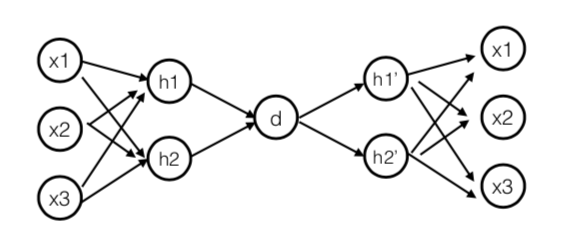

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

In [0]:
from sklearn.preprocessing import StandardScaler

df_ann = df_ann.drop(['Time'], axis=1)

df_ann['Amount'] = StandardScaler().fit_transform(df_ann['Amount'].values.reshape(-1, 1))

###Split data for Autocoders

In [0]:
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

In [0]:
train_x, test_x = train_test_split(df_ann,test_size = 0.2,random_state=42)
train_x = train_x[train_x.Class == 0] 
train_x = train_x.drop(['Class'], axis=1) 


test_y = test_x['Class']
test_x = test_x.drop(['Class'], axis=1)


train_x = train_x.values
test_x = test_x.values

In [228]:
train_x.shape

(227451, 29)

####Model Traning

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

We will train our model for 50 epochs with a batch size of 128 samples.

In [0]:
nb_epoch = 50
batch_size = 32

In [0]:
input_dim = train_x.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [237]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 29s 129us/step - loss: 0.8254 - acc: 0.5700 - val_loss: 0.7876 - val_acc: 0.6447
Epoch 2/50
227451/227451 [==============================] - 29s 129us/step - loss: 0.7472 - acc: 0.6572 - val_loss: 0.7723 - val_acc: 0.6628
Epoch 3/50
227451/227451 [==============================] - 30s 132us/step - loss: 0.7388 - acc: 0.6641 - val_loss: 0.7698 - val_acc: 0.6734
Epoch 4/50
227451/227451 [==============================] - 30s 130us/step - loss: 0.7346 - acc: 0.6684 - val_loss: 0.7654 - val_acc: 0.6810
Epoch 5/50
227451/227451 [==============================] - 29s 126us/step - loss: 0.7318 - acc: 0.6730 - val_loss: 0.7643 - val_acc: 0.6718
Epoch 6/50
227451/227451 [==============================] - 29s 128us/step - loss: 0.7302 - acc: 0.6760 - val_loss: 0.7631 - val_acc: 0.6753
Epoch 7/50
227451/227451 [==============================] - 29s 127us/step - loss: 0.7286 - acc: 0.6760

In [0]:
autoencoder = load_model('autoencoder_fraud.h5')

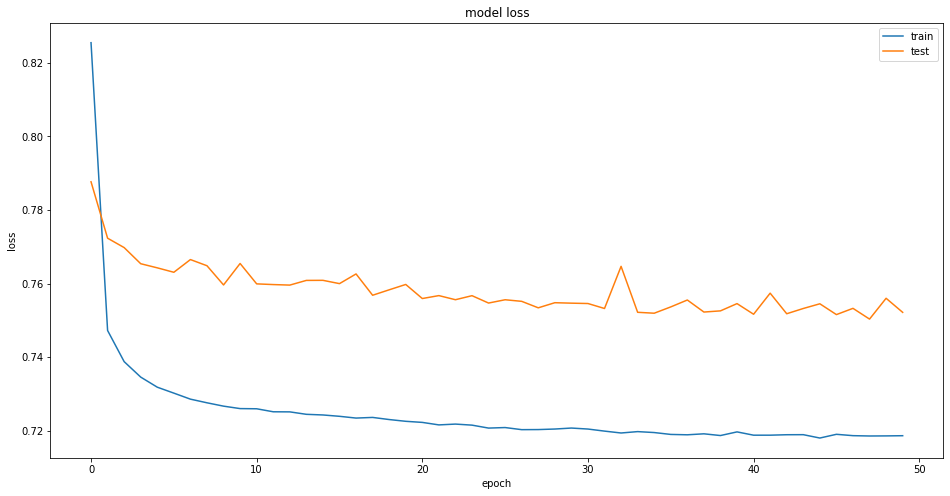

In [239]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

####Model Testing

In [0]:
predictions = autoencoder.predict(test_x)

In [241]:
predictions.shape

(56962, 29)

In [0]:
mse = np.mean(np.power(test_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class':test_y})

In [243]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.739484,0.001720
std,3.407012,0.041443
min,0.040852,0.000000
25%,0.244109,0.000000
50%,0.395830,0.000000
75%,0.636353,0.000000
max,257.138906,1.000000


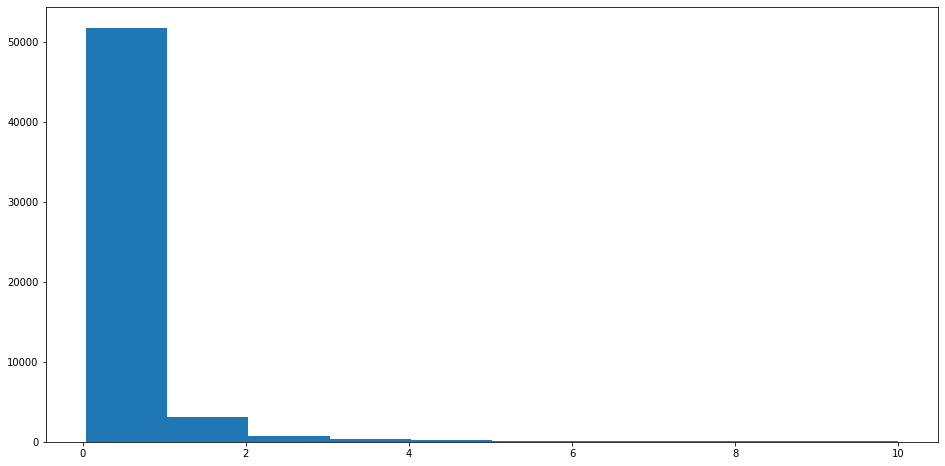

In [245]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

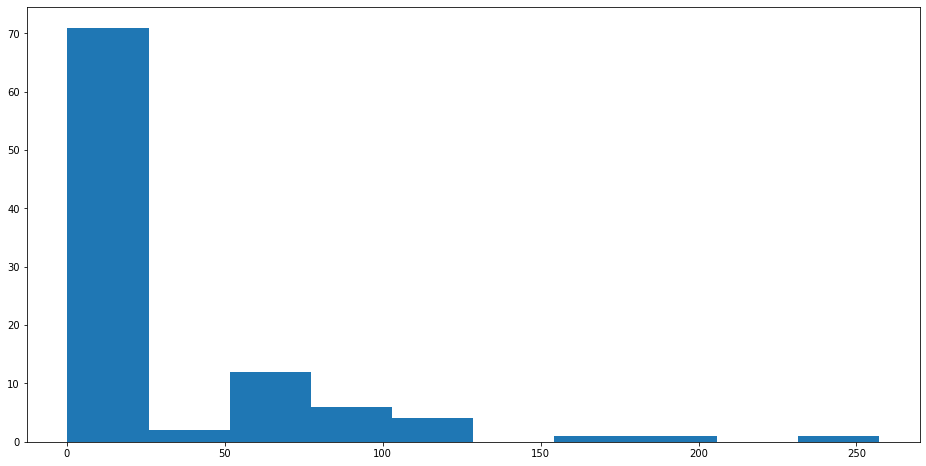

In [246]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

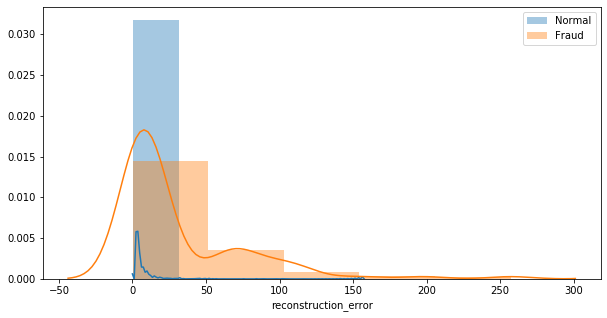

In [247]:
plt.figure(figsize = (10,5))
sns.distplot(error_df[error_df['true_class']==0]['reconstruction_error'], bins = 5, label = 'Normal')
sns.distplot(error_df[error_df['true_class']==1]['reconstruction_error'], bins=5, label = 'Fraud')
plt.legend()
plt.show()

In [0]:
threshold = 2.9

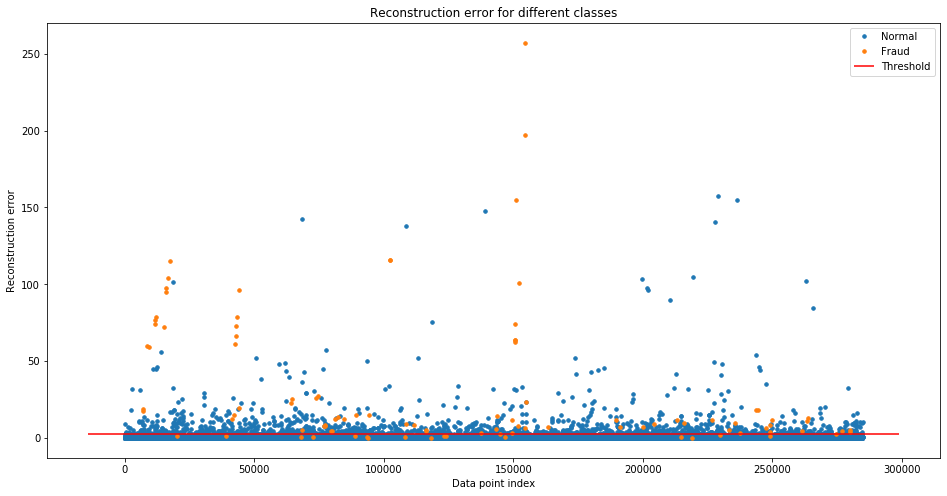

In [249]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

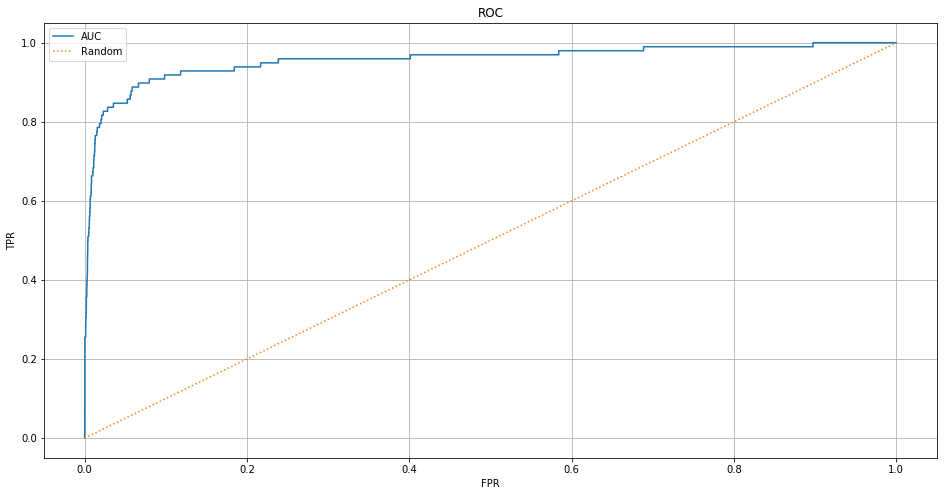

In [255]:
fpr, tpr, thres = roc_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show() 

In [0]:
LABELS = ['Normal', 'Fraud']
threshold = 2

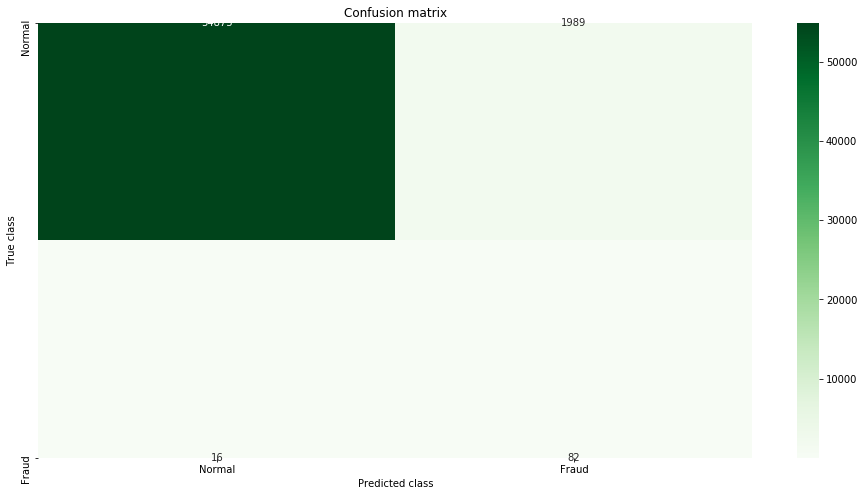

In [252]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [253]:
print("Area under ROC : ", roc_auc_score(error_df.true_class,y_pred ))

Area under ROC :  0.9008782501464289


In [254]:
print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.84      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.96      0.98     56962



####Result Summary on Autoencoders



Area under ROC :  0.9008782501464289

f1-score 0.96